<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset de dados de confiabilidade: https://drive.google.com/drive/folders/1b7jqK1A2XI1oZ4YhDXw_4xdnSTbfuBVK?usp=sharing

In [209]:
%%capture
pip install pyswarms

In [210]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [211]:
MAX_VALUE_CUSTO = 10000
fator_melhoria = 'expo'

In [212]:
# Custos MC e MP
CMC = 4000
CMP = 2000

In [213]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [214]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [215]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [216]:
 # Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)
    return fator

In [217]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [218]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [219]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [220]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

In [221]:
# Leitura dos dados de tempo: exemplo tese Marcos Coque Jr.
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DateSet/data.csv', sep=";")
df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,0.0
1,110,1,1,0.0,0.5,150.0
2,125,1,1,9.0,0.9,250.0
3,135,1,1,2.0,0.2,500.0
4,295,1,3,2.0,0.4,600.0


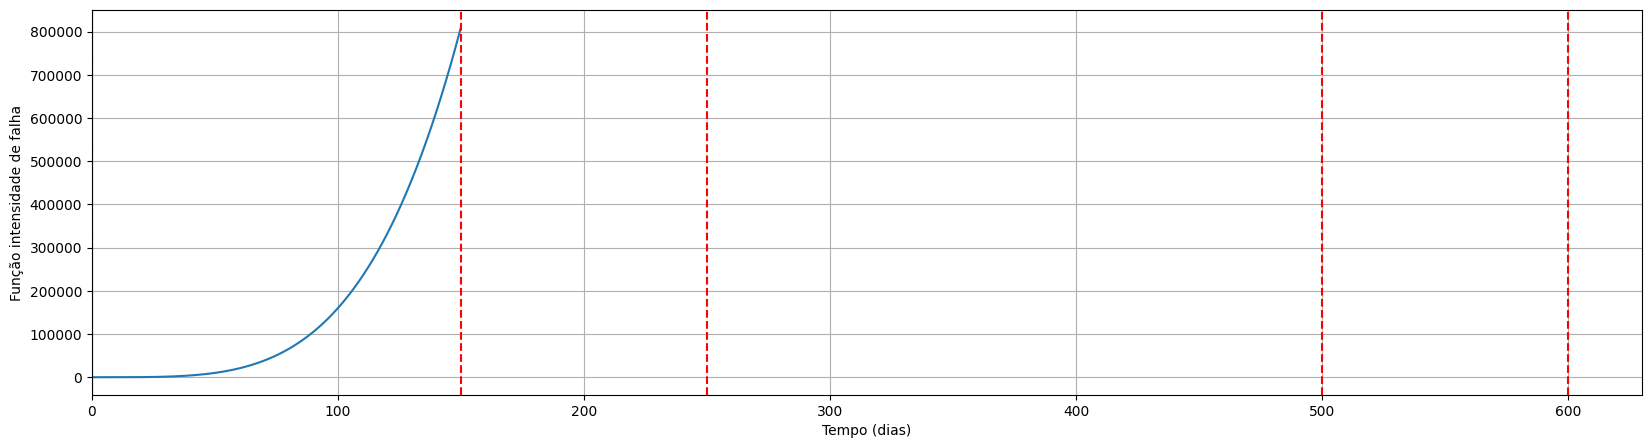

Fator ajuste:  [0.5506710358827784, 0.6321205588285577, 0.8347011117784134, 0.3296799539643607]


In [222]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

# Criação de variáveis para os parâmetros
lamb = 5
theta = 2

# Cria alguns cenários de teste
beta = 5

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [223]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0}

    results = [] # Lista para armazenar os resultados das funções objetivo


    # No PSO, como cada particula é um vetor de dimenções definidas, é
    # Necessario interar sobre o vetor de particulas
    for particle in x:
        T = [0]
        s_row = []
        cont = 0

        for number in particle:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    # A variável m é o número de sistemas em análise: em nosso exemplo m = 4
    # Para novos dados esse parâmetro deve ser ajustado
    # m = 4
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = 730
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)

    # Retorne os resultados da função objetivo como um array
    return np.array(results)

In [224]:
num_particles = 100
max_iterations = 100
dimensions = 24
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_bound = np.array([7.0] * dimensions)  # Limite superior dos valores em x
min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
bounds = (min_bound, max_bound)

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

pbest_cost = optimizer.swarm.pbest_cost

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-09-10 20:14:44,037 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   9%|▉         |9/100, best_cost=8.15e+10



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 17, 101, 134, 172, 219, 308, 352, 548]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 454.35424000000006, 2528456.917960726, 4633487.260542882, 11223649.573498998, 16117508.777661607, 59889213.564870216, 65222815.18941429, 3608068603.35954, 6159366941.013457]
Custo =  132313450702.01892


Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 140, 231, 407, 489, 535, 562, 576, 635, 668]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.25, 0.25, 0.75, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698

pyswarms.single.global_best:  26%|██▌       |26/100, best_cost=8.15e+10



Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 25, 56, 196, 256, 372, 683, 711]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 3125.0000000000005, 82204.55914795527, 51055780.32365777, 102066156.80337185, 151634123.34421977, 14204914626.390133, 14239746683.473082, 14264202362.28674]
Custo =  197451185022.0011


Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 54, 304, 352, 415, 529, 601, 689, 699]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de

pyswarms.single.global_best:  44%|████▍     |44/100, best_cost=8.15e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 25, 45, 81, 107, 160, 309, 376, 404, 469, 500, 626]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 3125.0000000000005, 24175.902433680876, 344385.1478257363, 1018724.3708674463, 3139493.6351933023, 127082071.96563222, 394192085.7555389, 549014899.1246104, 668171400.0204833, 731021631.8170094, 4574391852.810745, 5703044634.094862]
Custo =  222559711889.69278


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 46, 82, 253, 311, 383, 414, 446, 459, 495, 652, 695]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.75,

pyswarms.single.global_best:  63%|██████▎   |63/100, best_cost=8.15e+10



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 27, 47, 86, 90, 190, 270, 306, 384, 409, 427, 463, 491, 529, 615, 662]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 4591.65024, 29656.293317093572, 472265.979383552, 527490.2542740017, 13886547.73031968, 22632212.02673489, 25020932.085666943, 361800657.06058496, 507635570.1279975, 526376354.70303303, 581648683.0887408, 633964101.974978, 1250835026.5303378, 1718252942.1925392, 1770585616.583088, 2435506885.0173054]
Custo =  189968348294.13184


Número de ciclos de manuten

pyswarms.single.global_best:  83%|████████▎ |83/100, best_cost=8.15e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 27, 44, 84, 95, 276, 316, 361, 492, 528, 657, 665]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.25, 0.25, 0.75, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 4591.65024, 21015.414315283157, 438736.7743422158, 620832.9431409881, 150884226.05954236, 165605622.66235924, 320419192.1169369, 1839054709.6350284, 1855021222.740217, 2895758785.2456303, 2902351769.682819, 3532769910.087892]
Custo =  141173614490.90582


Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 49, 83, 104, 159, 184, 247, 273, 314, 401, 453, 492, 624, 632, 665]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.25, 0

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=8.15e+10




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 13, 49, 85, 102, 265, 322, 510, 592, 668, 704]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.5, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 118.81376000000002, 57300.01583108998, 442197.8157618651, 810210.4775710293, 104534124.18370563, 129875814.18585522, 987377960.7242326, 3017858443.578543, 3129853483.2887125, 4983471143.128679, 5018691295.974664]
Custo =  339022518655.86115


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 19, 45, 84, 167, 260, 315, 363, 485, 511, 667, 703]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.5, 0.25, 0.75, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539

2023-09-10 20:14:45,434 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81514778620.21527, best pos: [2.65783073 1.23986972 3.62704382 4.32930935 4.95583077 0.70503426
 2.12205496 4.52504856 0.22626067 0.38386427 2.26615428 1.49264081
 2.89690917 1.99703129 2.73372935 5.52352906 3.79493431 4.19118551
 4.33599637 3.83837248 1.27887874 6.75520504 5.13845282 1.69507486]
2023-09-10 20:14:45,442 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.15e+10
2023-09-10 20:14:45,461 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81514778620.21527, best pos: [2.65797891 1.23902415 3.62688675 4.3293256  4.95316215 6.54084203
 2.12175561 4.49481524 5.73495437 3.29447585 2.29013513 2.95779285
 2.89695525 2.0458287  2.73576305 4.73366692 3.80272018 4.19039226
 4.33593279 3.85829169 2.01727966 2.09122612 5.09833438 1.6949119 ]
2023-09-10 20:14:



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 40, 86, 176, 257, 309, 377, 485, 517, 590, 626, 669]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 32768.0, 683253.9976207248, 19140385.21059319, 39821070.34306024, 134592920.3850688, 191850929.40327185, 1375760676.8848555, 1449907811.7346954, 1774403661.9535522, 1804127044.8956954, 2084703723.2830658, 2670000606.0481043]
Custo =  151240061240.73804


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.15e+10
2023-09-10 20:14:45,488 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81514778620.21527, best pos: [2.6659209  1.23938078 3.62679083 4.32940107 4.95262694 1.97445469
 2.12207544 4.49890164 0.36310691 5.70185981 2.29679744 3.59174037
 2.89539656 2.04531494 2.73589636 5.65895086 3.80059096 4.19284053
 4.33585249 3.90235201 2.34749991 0.65863977 5.10246747 1.69502997]
2023-09-10 20:14:45,489 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 36, 87, 101, 209, 307, 357, 364, 452, 483, 621, 669]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.75, 0.25, 0.25, 0.5, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 19349.176320000002, 782787.2271767431, 1076482.8935806036, 21675418.785923213, 194766744.50096, 201761643.1334431, 228026603.91063437, 958382586.9669565, 1013330930.1993723, 1295631566.7944994, 1613224803.2491107, 2198521686.0141487]
Custo =  136858920418.39682


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.15e+10
2023-09-10 20:14:45,513 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81514778620.21527, best pos: [2.67106241 1.23982387 3.62677014 4.32945489 4.95301027 5.26899699
 2.12235969 4.50579927 3.18807002 2.04040664 2.29771878 4.42806025
 2.89401565 2.03717443 2.73560745 5.7527591  3.79756771 4.19461573
 4.33582059 3.93090991 3.27310145 5.12889495 5.11511517 1.69513723]
2023-09-10 20:14:45,519 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 32, 86, 312, 344, 440, 451, 482, 595, 603, 668]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 10737.41824, 791728.0575767461, 533556409.5927037, 548982046.5297525, 1262162186.569226, 1359107328.454655, 1413615390.451515, 1575994182.521074, 1607605199.3446715, 2056983174.5607128, 2653467335.2507105]
Custo =  171109088659.69904


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.15e+10
2023-09-10 20:14:45,541 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81514778620.21527, best pos: [2.67499886 1.24022977 3.62675498 4.32950111 4.95418252 1.68814768
 2.12252739 4.5157141  6.50666903 6.41443514 2.29040933 5.87407793
 2.89343311 2.01907655 2.73488977 5.09245291 3.79438372 4.19562474
 4.3357991  3.94489035 4.50885735 1.64840678 5.13109212 1.69523375]
2023-09-10 20:14:45,548 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 30, 85, 116, 170, 264, 323, 332, 422, 487, 649, 666, 713]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.75, 0.25, 0.25, 0.5, 0.5, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 7776.000000000001, 771663.4432946742, 1882185.4405227515, 4538982.543554817, 17304802.96608097, 24369660.912337456, 24868099.15208165, 590903855.384244, 1329238735.7605314, 2749021799.5465865, 2850919863.160476, 5376580303.895203, 5398148269.368153]
Custo =  351290579663.32477


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.15e+10
2023-09-10 20:14:45,751 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81514778620.21527, best pos: [2.67720553 1.24054221 3.62681368 4.32953675 4.95547742 6.1551845
 2.12263787 4.52619029 3.54694753 3.42379919 2.28157393 0.30634286
 2.89341757 1.99840814 2.73414538 3.88163579 3.79155049 4.19529503
 4.33582239 3.9406247  5.84964149 4.93710715 5.14674542 1.69529875]
2023-09-10 20:14:45,753 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 83, 103, 123, 184, 457, 492, 530, 581, 615, 640, 665, 703]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 1260493.00576, 1882056.572199962, 2065139.4049254782, 6337328.095930437, 983953825.3821423, 995852997.9661217, 1094883979.0687172, 1292862358.5801332, 1448733996.141149, 2334142164.096859, 3367126249.4325666, 5309438357.212657, 5346283748.736179]
Custo =  577330890879.9424


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.15e+10
2023-09-10 20:14:45,774 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81514778620.21527, best pos: [2.67861098 1.24080445 3.62691195 4.32955683 4.95672475 4.3065143
 2.12273682 4.53545082 0.73363499 0.89984736 2.27041862 2.36112779
 2.89438988 1.97946112 2.7334274  2.18749316 3.78999542 4.19498616
 4.33586585 3.91192174 6.70833688 0.5232413  5.15871969 1.6952915 ]
2023-09-10 20:14:45,776 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 81, 126, 389, 392, 448, 479, 497, 523, 643, 663, 696]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 1115771.00832, 4053690.804766188, 910594791.8060256, 910886728.0880066, 1367778395.7453966, 1707323873.5742433, 1939558423.7468736, 2347650819.3933954, 3215445071.5069637, 3334068929.962493, 4960748661.921679, 5009626085.214873]
Custo =  460906590998.4217


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.15e+10
2023-09-10 20:14:45,791 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81514778620.21527, best pos: [2.67984841 1.24091637 3.62702389 4.32955111 4.95761625 2.55101786
 2.1226368  4.54197547 5.79983702 6.27276229 2.2591658  4.67699917
 2.89582389 1.96681934 2.73281891 0.38862503 3.7888358  4.1938241
 4.33592619 3.88156255 0.01517358 3.95835817 5.16523966 1.69527464]
2023-09-10 20:14:45,793 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 30, 78, 128, 197, 438, 503, 518, 658, 662, 692]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 7776.000000000001, 475743.966165062, 3191959.645868126, 9864666.140230823, 611046656.8462803, 765502798.7196265, 994897360.9176645, 2177508516.137044, 2200220652.173097, 3648737595.6050253, 3705033600.9033756]
Custo =  336861673731.1049


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.15e+10
2023-09-10 20:14:45,809 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81514778620.21527, best pos: [2.67475744 1.24073736 3.62712672 4.32948917 4.95803339 1.41454169
 2.12240547 4.5434327  4.71169689 5.00466642 2.25044378 6.90553821
 2.8971737  1.95844795 2.73241859 6.5912149  3.78893612 4.19254933
 4.33598783 3.84360868 1.21776102 0.13124309 5.16413251 1.69525533]
2023-09-10 20:14:45,811 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 32, 77, 105, 129, 301, 433, 509, 520, 632, 661, 690]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 10737.41824, 423887.60596341855, 1097239.0167472868, 1378017.9553806083, 314457959.8978961, 414293736.45748186, 612247791.8979037, 783934510.5120435, 1523239956.4955113, 1697135534.3222852, 1902963706.7100568, 1963125703.8268294]
Custo =  168133137240.42087


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.15e+10
2023-09-10 20:14:45,828 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81514778620.21527, best pos: [2.66696826 1.24042392 3.62721373 4.32940775 4.95823485 1.00864209
 2.12217848 4.54133107 4.18039497 3.85160937 2.24274773 1.8903276
 2.89835071 1.95265797 2.73227064 5.12663589 3.78980896 4.19114831
 4.33604501 3.808463   3.01587847 3.28713906 5.15998873 1.69521037]
2023-09-10 20:14:45,829 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 36, 75, 94, 128, 194, 265, 307, 337, 399, 439, 466, 527, 661, 692]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 19349.176320000002, 337639.0825667389, 632253.9167767309, 1101895.5579168678, 3515185.291921081, 9705893.907951042, 23786103.84302341, 103328569.46963048, 165148019.7680356, 470259110.64328283, 736140362.8805873, 1692437224.7500646, 2007804938.458493, 2231452092.6951914, 2287748097.9935417]
Custo =  193388561138.2333


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.15e+10
2023-09-10 20:14:45,845 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81514778620.21527, best pos: [2.65839756 1.23999305 3.62725721 4.32932768 4.95779762 1.30535087
 2.12196212 4.536951   3.80512981 3.32542515 2.23821482 4.37264387
 2.89925303 1.96008713 2.73222138 3.12745014 3.79148122 4.18988797
 4.33608744 3.78263472 5.04945677 5.53227422 5.15620134 1.69514273]
2023-09-10 20:14:45,847 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 40, 74, 103, 125, 160, 306, 346, 417, 446, 469, 539, 582, 640, 661, 697]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.75, 0.25, 0.5, 0.25, 0.75, 0.25, 0.5, 0.5, 0.25, 0.75, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 32768.0, 294482.45947866456, 940694.5412715973, 1162290.8974479362, 5708401.827842451, 69067252.60013792, 185589504.12469295, 272984960.75598824, 511690073.3931311, 517399895.7001758, 1711977807.3731325, 1875598229.442631, 2208973991.6880307, 3059010418.187636, 3103235383.392676, 3150321506.6826425]
Custo =  331919200420.57654


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.15e+10
2023-09-10 20:14:45,859 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81514778620.21527, best pos: [2.65061251 1.23960307 3.62726839 4.32925279 4.95681934 2.25359094
 2.12177001 4.53224638 3.20284366 3.23755639 2.23783604 6.7030118
 2.89961036 1.97134091 2.73241669 1.33299524 3.7938602  4.18882646
 4.33612266 3.77018749 6.64514262 6.86674993 5.15028954 1.69507234]
2023-09-10 20:14:45,861 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 43, 74, 122, 176, 303, 355, 457, 576, 652, 662, 705]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.5, 0.25, 0.25, 0.75, 0.75, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 47042.70176, 285875.0983949364, 2439854.460152392, 5406547.171159935, 46042646.15253006, 77887338.58760525, 283587981.5467174, 2883464600.9211674, 5673999500.966844, 5682221985.799665, 5740450762.583344, 5774068146.087049]
Custo =  260576083683.33917


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.15e+10
2023-09-10 20:14:45,877 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81514778620.21527, best pos: [2.64392097 1.23932296 3.62721363 4.32918961 4.95571616 3.52496325
 2.12162242 4.52596602 3.00012604 3.73362062 2.24133014 1.12049185
 2.89936424 1.98290317 2.73285437 6.02871205 3.7961443  4.18798203
 4.33612882 3.77426795 1.24121742 0.35487484 5.1419427  1.69500927]
2023-09-10 20:14:45,879 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 44, 75, 200, 266, 359, 364, 587, 646, 662, 712]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.25, 0.25, 0.5, 0.25, 0.75, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 52773.19168, 304878.5306243019, 46336288.46043902, 62597582.47832632, 368181636.0435646, 387010418.1440794, 5726916915.788824, 6079431785.808063, 6734128954.658709, 6808302042.713547, 6831303817.970023]
Custo =  325104327644.26874


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.48e+10
2023-09-10 20:14:45,893 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 74810937748.53241, best pos: [2.64190156 1.23921686 3.62715472 4.32913506 4.95473839 5.08758485
 2.12157461 4.52020546 2.99249702 4.38206798 2.24708739 3.13192978
 2.89884787 1.99573562 2.73341155 3.15471602 3.79815332 4.18806313
 4.33611323 3.78472641 3.37807979 0.92546224 5.13372886 1.69496859]
2023-09-10 20:14:45,895 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 44, 77, 161, 370, 393, 456, 572, 610, 663, 718]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 52773.19168, 350662.44364771026, 12485621.259726672, 456551354.62437606, 571086681.8871818, 674195692.8098512, 827350402.9568712, 998116872.2014999, 1060564084.6145893, 1148029271.5555582, 1162719678.3322737]
Custo =  74810937748.53241


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.48e+10
2023-09-10 20:14:45,907 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 74810937748.53241, best pos: [2.6400841  1.23912138 3.6271017  4.32908597 4.9538584  0.19394429
 2.12153158 4.51502095 3.6856309  5.66567061 2.25226892 5.64222392
 2.89838313 2.00728482 2.73391302 6.8681196  3.79996144 4.18813611
 4.3360992  3.79413902 6.00125594 0.7389909  5.12633641 1.69493197]
2023-09-10 20:14:45,908 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 44, 79, 188, 374, 427, 511, 574, 609, 635, 664]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 52773.19168, 402697.7811438911, 30764703.68989897, 376376431.314247, 441065567.32249784, 671072161.538317, 914661385.6471894, 940540364.3382968, 1831922807.5093272, 2008936497.2836084, 2650791744.860003]
Custo =  243301736424.92126


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.48e+10
2023-09-10 20:14:45,920 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 74810937748.53241, best pos: [2.63898789 1.23904374 3.62705399 4.32905544 4.95326563 3.38931099
 2.12150402 4.51054486 4.97756775 0.45718718 2.25648126 1.42491671
 2.89796953 2.01661051 2.73424003 2.73815511 3.80142562 4.18819007
 4.33608782 3.80113689 1.7719237  6.89717727 5.12142008 1.69490675]
2023-09-10 20:14:45,922 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 42, 80, 111, 265, 328, 373, 431, 457, 615, 664]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 41821.194240000004, 441587.87866750476, 1373166.3999454495, 91179079.9955586, 122430624.05148953, 154174852.65641898, 558192359.2901378, 594640833.5152748, 1732099577.904094, 2047943913.2605877, 5898429282.81328]
Custo =  328717942327.09546


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.48e+10
2023-09-10 20:14:45,940 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 74810937748.53241, best pos: [2.63833884 1.23899462 3.62703732 4.32905013 4.95274348 6.98617804
 2.12149435 4.50822414 6.60212051 3.42147771 2.25923856 4.6672768
 2.89769732 2.01949596 2.73434784 5.36259817 3.80228675 4.18822275
 4.33608374 3.80601828 5.43773268 3.65553918 5.11922837 1.69489353]
2023-09-10 20:14:45,941 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 41, 81, 170, 288, 323, 334, 367, 395, 429, 507, 665]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 37073.98432, 479899.5826238746, 16478978.866665473, 77550622.90541948, 91080351.25170685, 120085754.81388997, 243100335.63237888, 265578816.5587794, 304165801.1909857, 352227162.1446584, 1833063085.1681516, 2463481225.573225]
Custo =  116341740049.63882


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.48e+10
2023-09-10 20:14:45,953 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 74810937748.53241, best pos: [2.63825301 1.2389663  3.62703099 4.32905443 4.952463   3.60248952
 2.12150187 4.50956273 1.02913773 6.92835341 2.25878988 1.24885678
 2.89764128 2.01918829 2.73428876 0.2491235  3.80235075 4.18824929
 4.3360826  3.80721827 2.22802036 6.50975514 5.11786257 1.69488819]
2023-09-10 20:14:45,954 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 39, 82, 279, 319, 343, 362, 392, 424, 466, 504, 584, 665]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 28871.743680000003, 530643.2382806551, 293056154.24695873, 308305485.3541307, 319241583.44476223, 387582978.9515717, 411194851.4789639, 445598242.9554242, 513386067.1433806, 594937516.0381476, 2471902247.1936812, 3050615112.1345787, 3681033252.539652]
Custo =  207435153660.75742


pyswarms.single.global_best:   0%|          |0/1, best_cost=7.48e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 36, 83, 169, 269, 275, 318, 352, 392, 501, 538, 609, 665]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 19349.176320000002, 599451.2889557153, 15572430.294536749, 51169391.78269653, 51321518.16248995, 140066886.48124003, 143566777.30907798, 336607647.03901666, 649726147.6400611, 1293305757.824081, 1646170755.8050253, 2016662799.107453, 2135203737.8307643]
Custo =  164949482962.0338


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.48e+10
2023-09-10 20:14:45,967 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 74810937748.53241, best pos: [2.63882994 1.23901203 3.62702835 4.32906178 4.9527789  0.62478539
 2.12152235 4.51300893 3.38700926 3.27763319 2.25702336 5.63500042
 2.89775155 2.01243012 2.73409999 2.21054524 3.80119218 4.18827304
 4.33608634 3.8022979  6.68336222 1.65762073 5.11920881 1.69488901]
2023-09-10 20:14:45,969 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.48e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 34, 83, 167, 186, 321, 356, 499, 531, 588, 621, 665]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 14539.335680000002, 622805.6628530564, 14521972.48094594, 15319360.702045383, 126314428.7892801, 145873411.63390315, 1901873540.5989294, 1984139056.876418, 2220543456.433012, 2377221046.926739, 4166186211.3657312, 4796604351.770804]
Custo =  302816396602.51



2023-09-10 20:14:45,982 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 74810937748.53241, best pos: [2.63967411 1.239077   3.62705348 4.3290772  4.95312481 5.38962524
 2.12155023 4.51699877 6.20476836 0.1293562  2.25514692 3.01893693
 2.89807978 2.00339033 2.73372966 4.06838208 3.79951802 4.18828024
 4.33609534 3.79758979 4.10107707 3.4894193  5.12093455 1.6949016 ]
2023-09-10 20:14:45,984 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.48e+10



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 33, 82, 110, 263, 327, 358, 498, 526, 664]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 12523.325760000002, 593100.4191669014, 1404055.1739848717, 88101763.44113432, 233578947.30963898, 250885979.7315503, 1955638668.8698583, 2024076849.329416, 3218402766.3053236, 3860258013.881718]
Custo =  145759422932.97028



2023-09-10 20:14:45,997 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 74810937748.53241, best pos: [2.64067521 1.23915429 3.62709104 4.32909524 4.95371009 3.29788586
 2.12158213 4.52140407 1.59105895 4.5079674  2.25293064 0.67725206
 2.89842583 1.99327658 2.73336051 5.51764081 3.79793439 4.18822664
 4.33610841 3.79058545 1.70205797 4.80510555 5.12371505 1.69491854]
2023-09-10 20:14:45,999 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.48e+10
2023-09-10 20:14:46,011 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 74810937748.53241, best pos: [2.6416112  1.2392246  3.62713833 4.32911492 4.9544469  1.79710141
 2.12160991 4.52514048 4.49440492 2.13156517 2.24938773 5.69609247
 2.89882843 1.9845232  2.7330384  6.24192326 3.79651829 4.18813541
 4.33612156 3.78352947 6.83218905 5.79451747 5.12786862 1.69494175]
2023-09-10 20:14



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 32, 81, 110, 156, 250, 354, 497, 526, 664]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 10737.41824, 564628.6814841488, 1404600.649961499, 2916537.5822547553, 28163614.995049644, 351838700.30426437, 2080015769.6986728, 2151138917.591498, 3345464834.5674057, 3987320082.1438003]
Custo =  145486442298.4083


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.48e+10
2023-09-10 20:14:46,027 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 74810937748.53241, best pos: [2.64245837 1.23928726 3.62718334 4.32913757 4.95512157 0.73906244
 2.12163486 4.52747854 0.72007802 0.15304717 2.2457572  3.88413969
 2.89919496 1.97964422 2.73278629 5.99707313 3.79569726 4.18804635
 4.33613304 3.77728798 4.51200156 5.39541564 5.13237729 1.69496992]
2023-09-10 20:14:46,028 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 32, 80, 110, 158, 348, 401, 467, 498, 531, 574, 640, 663, 716]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 10737.41824, 526317.8805416146, 1395500.3977450891, 3094779.363906174, 188651718.80546516, 465517832.95610535, 585178214.7162104, 982410670.8717815, 1067538958.8619803, 1222649785.0453238, 1611689081.6578562, 2552309501.8118033, 3014392168.866299, 3031776422.193372]
Custo =  335364656091.2301


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.48e+10
2023-09-10 20:14:46,040 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 74810937748.53241, best pos: [2.64316603 1.23933892 3.62721773 4.32915768 4.9557089  1.03198816
 2.12164392 4.52878661 4.87009748 5.95091817 2.24270814 2.20415149
 2.89943294 1.97765999 2.73260028 5.44806446 3.79520627 4.18796727
 4.33614303 3.77356143 2.16271141 4.29627272 5.13659695 1.69499491]
2023-09-10 20:14:46,042 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 33, 78, 120, 338, 500, 537, 573, 663, 711]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 12523.325760000002, 446769.64613926463, 2189106.43970893, 398287849.97950053, 638896443.663157, 739985578.9784592, 866064960.8982766, 1520838284.0282197, 1922813563.6225452, 1947269242.436203]
Custo =  106099791144.4706


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:46,056 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64354595 1.2393622  3.62723764 4.32917056 4.95605945 2.0772287
 2.1216449  4.5293847  2.19426968 4.65465606 2.24110756 0.72104677
 2.89950197 1.97671183 2.73248724 4.43929264 3.79563352 4.18791673
 4.33614465 3.77306791 0.1987429  2.42914789 5.13968963 1.69501691]
2023-09-10 20:14:46,057 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 34, 77, 108, 121, 172, 479, 501, 622, 663, 706]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 14539.335680000002, 407009.43178738095, 1242341.358226978, 1341121.0848445962, 10189556.005408546, 1582790052.8927293, 1626329974.3274813, 1839497037.295623, 2096404182.786205, 2154935864.6731467, 2186972642.428513]
Custo =  72171880233.77661


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:46,072 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64388787 1.23938316 3.62725556 4.32918215 4.95637495 3.01794519
 2.12164578 4.52992298 6.78602467 3.48802017 2.23966705 6.38625252
 2.89956409 1.97585849 2.73238551 3.531398   3.79601804 4.18787124
 4.33614611 3.77262374 5.43117124 0.74873554 5.14247305 1.69503671]
2023-09-10 20:14:46,074 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 35, 76, 104, 120, 288, 502, 628, 663, 702]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 16807.0, 370689.81202543946, 1018804.6068317782, 1143068.6730385097, 138594716.1777303, 672089410.9067588, 4565187417.676714, 4780951370.608604, 5084628117.266061, 5123121525.089528]
Custo =  198299164741.3112


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:46,088 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64416892 1.23939821 3.62726911 4.32919026 4.95658001 3.71998294
 2.12164641 4.53030293 3.5917115  2.4872297  2.23874308 3.6327486
 2.89960994 1.97520408 2.73230425 2.86415597 3.79627617 4.18783662
 4.3361474  3.77230065 3.01692933 6.73109693 5.14424926 1.69505142]
2023-09-10 20:14:46,089 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 37, 75, 96, 161, 263, 291, 408, 504, 663, 700]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 331803.45383348997, 685309.0397809674, 3918678.071985759, 19871135.204687648, 21214556.790637292, 84624870.19142212, 349091256.51250315, 6428711052.2253685, 6712177800.018312, 6754036819.252003]
Custo =  203478779177.3838


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:46,104 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.6444101  1.23940281 3.62727485 4.32919322 4.95663304 4.14330658
 2.1216467  4.53057647 0.64090015 2.06348554 2.23810349 0.33048155
 2.89962087 1.97482746 2.73224197 2.68166978 3.79645174 4.18781012
 4.33614776 3.77222482 0.03056794 4.53022263 5.1445672  1.69506453]
2023-09-10 20:14:46,106 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 39, 76, 174, 293, 340, 460, 505, 658, 663, 701]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.25, 0.25, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 28871.743680000003, 346151.56877903553, 20159468.009605207, 85511164.8614324, 90864058.87932353, 182301313.34443498, 783916120.5333388, 6461871044.311534, 6490496712.453617, 6783996769.981523, 6824161282.571217]
Custo =  267801489134.73163


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:46,118 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.6444963  1.23939616 3.62727754 4.32919347 4.95664631 4.02379082
 2.12164664 4.53080618 5.26783338 1.80600477 2.23761754 4.45978759
 2.8996243  1.9746637  2.73220289 2.65107972 3.79638307 4.18781183
 4.33614788 3.77216942 4.35606176 1.96708093 5.14425172 1.69506389]
2023-09-10 20:14:46,120 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 40, 76, 178, 362, 506, 590, 615, 635, 664, 703]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 32768.0, 341222.7033300746, 23071294.149579164, 331965251.9960154, 514464661.41677916, 903360536.9174588, 1015080148.0389435, 1115117122.246844, 1143205938.5514696, 1448573506.2028964, 1485418897.7264187]
Custo =  109767470946.28038


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:46,132 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64453235 1.23938636 3.62727428 4.32918984 4.95659907 3.88587355
 2.12164655 4.5308147  2.29360817 2.09450793 2.23796234 1.74466101
 2.89959736 1.97482579 2.73222503 2.77662554 3.79627407 4.18783705
 4.33614797 3.77228223 1.85792032 6.7794572  5.14378727 1.69505754]
2023-09-10 20:14:46,134 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 40, 77, 103, 161, 258, 365, 412, 506, 575, 613, 664, 706]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.75, 0.25, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 32768.0, 366934.965280569, 945826.5301964711, 3515323.3431570553, 90094547.75183833, 128517486.704619, 403934429.148902, 664094083.0191352, 2194601456.864569, 2368655009.7883863, 2428046211.1720047, 2764982294.7715178, 2797019072.526884]
Custo =  188955922296.75876


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:46,147 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64433787 1.23937246 3.62726736 4.32918214 4.95644065 3.37613452
 2.12164616 4.53068546 6.59611797 2.81154563 2.2387218  6.28867229
 2.89956025 1.97523216 2.73226069 3.01174304 3.79614872 4.18787904
 4.33614747 3.77239327 6.53512891 3.79018454 5.14238741 1.69504471]
2023-09-10 20:14:46,148 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 40, 78, 194, 331, 366, 478, 506, 647, 664, 709]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 32768.0, 394310.474188844, 37489603.94060942, 162590215.67044297, 166778189.95253575, 252795005.56184265, 311623507.4909626, 643425882.8886402, 744117887.3672897, 3111561798.131669, 3138986720.7514725]
Custo =  265696105805.87216


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:46,161 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64407136 1.23935915 3.62725467 4.32917505 4.95622082 2.7514048
 2.1216456  4.53039588 3.22913314 3.69872329 2.24000691 3.82723363
 2.89952135 1.97573282 2.73231567 3.28216354 3.7959177  4.18792469
 4.33614693 3.77262295 4.28360935 1.01047922 5.14064426 1.69502656]




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 39, 78, 116, 190, 366, 418, 505, 614, 630, 664, 712]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 28871.743680000003, 400344.6803528751, 1770393.1799458906, 8643746.232544275, 295794691.66293514, 617394614.5806518, 848817434.6831926, 1490252729.184828, 1567026433.4635837, 1601344339.7333617, 4164289938.792089, 4187291714.048566]
Custo =  307921595745.4268


2023-09-10 20:14:46,163 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 38, 79, 91, 170, 271, 329, 363, 400, 420, 458, 504, 609, 664, 714]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.25, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator: 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:46,344 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64375133 1.23934761 3.62724086 4.32916849 4.95598559 2.12700268
 2.12164488 4.53009774 6.92952629 4.64226644 2.24146296 1.33216227
 2.89948295 1.97646898 2.73238451 3.86335737 3.79565344 4.18796486
 4.33614617 3.77284016 1.12473232 5.7981276  5.13906121 1.69500944]
2023-09-10 20:14:46,345 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 25355.253760000003, 437211.4203533252, 603479.2062018864, 6350643.311967902, 22889444.3995018, 158487645.67538452, 279587579.5085945, 473992960.9959306, 493668717.1891902, 838368715.583282, 940186186.1160558, 3824738763.795087, 4185460914.750057, 4613303544.182087, 4633457507.878606]
Custo =  270120733081.77347


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:46,356 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64343137 1.2393375  3.62722793 4.329163   4.95579365 1.55760718
 2.12164425 4.52961564 3.84668234 5.49403777 2.24273917 6.01119987
 2.89945154 1.97714294 2.732473   4.43896157 3.79541328 4.18800075
 4.33614523 3.77303757 5.26763089 3.1496318  5.13771203 1.69499422]
2023-09-10 20:14:46,358 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 37, 80, 118, 246, 329, 356, 361, 421, 450, 503, 586, 664, 716]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.75, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 477706.06832863926, 1943284.8704702144, 49244819.6568226, 65037335.75436158, 67621232.69106606, 85835531.63756427, 157874158.80012608, 196623314.62374777, 316373546.9587491, 689715281.2279234, 1238573390.138983, 1318535099.1447268, 1335919352.4717996]
Custo =  93834355342.19647


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:46,376 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64317134 1.23933208 3.62721802 4.32915966 4.9556296  1.09172234
 2.1216438  4.5291802  1.03150474 6.16567818 2.24361898 3.69316708
 2.89943334 1.97770424 2.73255521 4.95709851 3.79521607 4.188027
 4.33614436 3.77321897 2.17524967 0.55078524 5.13699864 1.69498435]




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 37, 80, 240, 329, 408, 421, 503, 539, 620, 664, 717]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5, 0.75, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 477706.06832863926, 126549432.27576141, 180883688.69810122, 275055423.73723185, 361696551.12447435, 571833474.8772911, 671272320.3314043, 1116938658.2098489, 1396579369.3630311, 1479134988.8477352, 1495162974.244381]
Custo =  116957293489.98692


2023-09-10 20:14:46,378 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=7.22e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 36, 80, 181, 295, 334, 400, 502, 538, 598, 637, 664, 717]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.75, 0.75, 0.25, 0.5, 0.5, 0.5, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 19349.176320000002, 486506.1128180088, 24316075.628554624, 85354378.93046491, 183959648.662421, 200759781.62358755, 280827962.449186, 907620168.3506153, 1175668640.0975256, 1383672922.2785938, 1547631474.8087075, 4448187132.735371, 4464215118.132016]
Custo =  374380493750.8629


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:46,391 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64299288 1.23933558 3.62720941 4.3291593  4.95549373 0.68020243
 2.12164357 4.52882957 5.50002775 6.66452445 2.24372159 1.35900847
 2.89943583 1.97803027 2.73262157 5.4095989  3.79515846 4.18802983
 4.33614359 3.77335483 6.07770192 5.47016304 5.13654314 1.69498045]
2023-09-10 20:14:46,394 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:46,412 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64297141 1.2393466  3.62720943 4.32916093 4.95549721 0.4904616
 2.12164342 4.52865068 2.62420536 6.68675701 2.24351194 6.20461969
 2.89943831 1.97831459 2.73267132 5.81363057 3.79522187 4.18801776
 4.33614293 3.773



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 35, 80, 451, 502, 538, 574, 656, 663, 715]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 16807.0, 495784.44022600644, 4158807432.882386, 4272244742.156523, 4899036948.057953, 5025973297.190712, 5584561334.564647, 5624818790.046684, 8440724297.678444, 8459483784.286919]
Custo =  409385811750.3904


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:46,439 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64305958 1.23935777 3.62721662 4.32916443 4.95550136 0.52193762
 2.12164338 4.52868577 6.99743199 6.64026726 2.24283871 3.40929768
 2.89945836 1.97841524 2.73269492 5.83355949 3.79533457 4.18800496
 4.33614266 3.77344753 6.2373635  0.85515534 5.13706842 1.69499233]
2023-09-10 20:14:46,446 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 35, 80, 102, 201, 501, 538, 608, 663, 714]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 16807.0, 495784.44022600644, 967908.4685249329, 16121254.60771667, 1576678467.1416676, 2220258077.3256874, 2564817362.4131336, 2923458491.045701, 3361007424.2257347, 3381161387.9222536]
Custo =  176254346050.6913


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:46,467 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64326028 1.23936842 3.62722734 4.32916907 4.95557402 0.66547083
 2.1216438  4.52889367 3.68621711 6.04918411 2.24181943 0.57920757
 2.89948373 1.97847738 2.73267858 5.52556761 3.79547261 4.18797606
 4.33614264 3.77344346 2.134969   6.18102632 5.13780598 1.69500175]
2023-09-10 20:14:46,473 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 35, 79, 159, 204, 279, 340, 501, 598, 636, 663, 712]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.25, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 16807.0, 461648.55334176944, 11339875.409672074, 14920045.04187879, 38496690.21536002, 47299619.31015767, 2064853088.8451397, 2560509157.5790067, 2761369940.1289287, 3861567640.717016, 4275239426.9767118, 4298241202.233189]
Custo =  296320273998.59296


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:46,494 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64351101 1.2393777  3.62723994 4.32917331 4.95569147 0.90544978
 2.12164429 4.52918535 0.30395728 5.41910352 2.24086929 5.07179044
 2.89950658 1.97845112 2.73263416 5.21159115 3.79561815 4.18793662
 4.33614267 3.77340308 5.12271241 4.16232417 5.13868079 1.69501441]
2023-09-10 20:14:46,496 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 35, 79, 114, 175, 502, 589, 652, 663, 711]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 16807.0, 461648.55334176944, 1634944.5137278326, 5292001.287821433, 2943514820.176464, 5048429527.689778, 5443185162.386365, 5898248201.97447, 6300223481.568796, 6324679160.382454]
Custo =  362323334467.0366


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:46,521 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64373746 1.23938361 3.6272507  4.32917674 4.95590068 1.24464978
 2.12164479 4.52946418 4.63093631 4.7594291  2.24003353 1.5278413
 2.89952647 1.97834532 2.73255969 4.91359073 3.79575132 4.18790003
 4.33614326 3.77336457 0.97733169 2.21517106 5.13974856 1.69502591]
2023-09-10 20:14:46,527 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 36, 78, 97, 268, 270, 339, 414, 502, 590, 659, 663, 709]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 19349.176320000002, 421485.86197596684, 755875.7727668849, 121431860.48491408, 121746729.5215738, 133033179.89039029, 225042501.53488573, 455231310.9703027, 552017996.6153907, 1010715819.2766728, 1177373315.4206934, 1556431507.198052, 1583856429.8178556]
Custo =  255421444806.12604


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:46,547 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64390087 1.23938699 3.62725739 4.32917867 4.95610767 1.69585241
 2.12164525 4.52970256 2.09024233 4.14306893 2.23936731 5.10374621
 2.89954111 1.97776846 2.7324738  4.58546186 3.79584273 4.18786767
 4.3361438  3.77332547 4.1793287  0.51224703 5.14070804 1.6950349 ]




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 37, 78, 181, 256, 401, 503, 663, 708]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 24889758.445148565, 42678563.187213674, 150430974.1258132, 437584063.51790327, 1933173224.5525594, 2301007585.552299, 2329948432.2914286]
Custo =  91521347864.572


2023-09-10 20:14:46,550 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:46,571 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64395904 1.23938429 3.62725851 4.32917839 4.9562918  2.12518348
 2.12164561 4.52984297 6.81963956 3.66651705 2.23890138 1.60528685
 2.89954488 1.97703711 2.73239727 4.27142873 3.79586356 4.18784787
 4.33614454 3.77323181 6.86725462 6.19138247 5.14140571 1.69504281]




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 38, 77, 159, 251, 281, 350, 394, 503, 658, 664, 707]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 25355.253760000003, 378384.07010291156, 11607610.64394037, 36090325.13614482, 37419864.51293432, 243219404.02297035, 250972424.52315265, 568443949.2295605, 6319572398.239971, 6354208118.08109, 6701965248.959403, 6732443281.354012]
Custo =  235270670162.5656


2023-09-10 20:14:46,577 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:46,596 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64395345 1.2393788  3.62725916 4.32917705 4.95645347 2.50942337
 2.12164589 4.52993667 3.64294595 3.31355242 2.23880816 5.30060376
 2.89954055 1.97631593 2.7323462  4.03659259 3.79586518 4.18783864
 4.33614523 3.77310353 1.11855762 4.31432649 5.14185191 1.69504615]




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 38, 77, 90, 159, 504, 584, 652, 664, 706]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 25355.253760000003, 378384.07010291156, 550015.6777388521, 4089286.483667805, 3426256985.7995095, 3777589315.8658805, 4210372053.6617737, 4280606694.885799, 4617542778.4853115, 4649579556.240678]
Custo =  143838755795.24506


2023-09-10 20:14:46,601 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 38, 77, 104, 162, 203, 264, 504, 642, 664, 706]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 25355.253760000003, 378384.07010291156, 1003224.2810787439, 3621634.9361270927, 6677639.155569847, 65343360.98292655, 828645812.1459346, 1890733857.9079552, 2022651622.1079795, 2359587705.7074924, 2391624483.4628587]
Custo =  109377636853.93532



2023-09-10 20:14:46,624 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64391677 1.2393691  3.62725866 4.32917427 4.95654801 2.80791654
 2.12164607 4.52993011 0.63076192 3.09864898 2.23925272 2.24323196
 2.89953303 1.97572148 2.73232356 3.89831878 3.79583945 4.18784148
 4.33614584 3.7729799  2.79443415 2.54510135 5.14221722 1.69504633]
2023-09-10 20:14:46,629 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:46,649 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64384929 1.23935931 3.62725819 4.3291715  4.95652446 3.0068019
 2.12164592 4.52978587 5.32130419 3.21498433 2.24008179 6.48226371
 2.89951912 1.97525107 2.73234477 3.82894249 3.79575888 4.18785245
 4.33614623 3.77288338 4.36634888 0.94826305 5.14229828 1.69504282]




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 38, 77, 192, 250, 276, 360, 504, 631, 664, 706]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 25355.253760000003, 378384.07010291156, 35685709.4651183, 46392755.70514567, 51598627.39355562, 330894204.7147434, 2170996208.6348605, 3053198780.915819, 3256749085.1321697, 3593685168.731683, 3625721946.487049]
Custo =  157107298826.3531


2023-09-10 20:14:46,651 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:46,673 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64376846 1.23935118 3.6272577  4.32916901 4.9563859  3.12986778
 2.12164565 4.52956621 3.08074654 3.34483293 2.24087674 2.92098898
 2.89950421 1.97492677 2.73239156 3.89332086 3.7956626  4.1878633
 4.33614645 3.77284863 5.43505815 6.60756279 5.14184695 1.69503598]




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 38, 77, 187, 361, 504, 574, 664, 707]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.5, 0.5, 0.75, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 25355.253760000003, 378384.07010291156, 30543999.24971915, 300032985.69079137, 2127087326.479452, 2404785557.4602985, 3063222908.78615, 3122058682.1427827, 3152536714.537391]
Custo =  114343348613.84877


2023-09-10 20:14:46,675 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:46,696 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64366995 1.2393463  3.62725412 4.32916684 4.95619403 3.00049764
 2.12164534 4.52933308 0.93561598 3.49062697 2.24163018 6.22392568
 2.89949022 1.97476043 2.7324422  4.07517688 3.79556776 4.18787566
 4.33614657 3.77286218 0.03756186 5.3201591  5.14087137 1.69502564]




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 37, 78, 98, 153, 269, 360, 419, 504, 584, 664, 709]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 780223.3447952543, 2763368.7152803047, 27161259.274748642, 329521604.63714516, 398760546.1935686, 621194622.5222147, 699932868.845834, 1266472080.5169473, 1329671115.3006983, 1357096037.920502]
Custo =  72656986379.93085


2023-09-10 20:14:46,701 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 14 5


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:47,028 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64354439 1.23934306 3.62724774 4.32916585 4.95601439 2.78715127
 2.12164499 4.52912997 6.18761327 3.720138   2.24229455 2.35449219
 2.89948068 1.97503194 2.73249606 4.25745038 3.79550124 4.1878897
 4.33614642 3.77289801 2.20857944 4.04601456 5.13974764 1.6950154 ]
2023-09-10 20:14:47,030 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Tempos para manutenções preventivas: [0, 37, 78, 104, 165, 257, 297, 331, 396, 504, 581, 602, 655, 664, 710]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 1015675.8749964125, 4072698.921240731, 15401346.309945393, 18000003.520688523, 101389354.94425695, 117204800.08234301, 208894862.68040368, 536940874.1921449, 622265914.2272766, 682083518.7338235, 689513989.8444451, 3121545536.2541075, 3147475500.6238995]
Custo =  273043475255.22305


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:47,058 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64343143 1.23934557 3.62724027 4.32916581 4.95586015 2.41120688
 2.12164467 4.52901737 4.56547    4.10324329 2.2426623  5.43823606
 2.89947713 1.9755335  2.73254215 4.44630285 3.79546548 4.18790713
 4.33614589 3.77295336 4.42917291 2.50962614 5.1387236  1.69500634]
2023-09-10 20:14:47,059 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 36, 79, 104, 353, 470, 503, 578, 612, 646, 664, 712]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 19349.176320000002, 453027.7594063263, 1031773.5421749898, 626929666.2630996, 717967366.1533124, 1157282631.2377236, 2849869680.8672357, 3002796300.2913895, 3033784218.132648, 3777869267.124505, 6340814866.183232, 6363816641.439709]
Custo =  562503265420.6759


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:47,083 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64335164 1.23934854 3.62723315 4.32916643 4.95576582 2.04828254
 2.1216444  4.52892077 2.65970596 4.55828493 2.24265858 0.65223736
 2.89947545 1.97627457 2.73257513 4.61512151 3.79545016 4.18792352
 4.33614509 3.77303577 5.86833888 1.10416845 5.13787577 1.69500091]
2023-09-10 20:14:47,089 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 36, 79, 94, 350, 462, 503, 572, 644, 664, 713]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 19349.176320000002, 453027.7594063263, 687668.2864977777, 663626100.8445716, 742131147.8220168, 758278818.8359805, 1027455320.9378879, 1470447738.8782601, 1488455564.4388716, 4117735347.411784, 4139303312.8847346]
Custo =  278369201854.67303


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:47,110 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64331518 1.2393524  3.62722697 4.3291678  4.95571302 1.7290756
 2.12164431 4.52887052 0.91092672 4.98685506 2.24223144 3.35425144
 2.89947484 1.97695607 2.73259775 4.72804571 3.79546006 4.18793797
 4.33614432 3.77311733 6.78066705 6.89518466 5.13744321 1.69499681]
2023-09-10 20:14:47,112 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 36, 80, 152, 450, 503, 647, 664, 714]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 19349.176320000002, 486506.1128180088, 8537910.973996282, 1785255819.3965802, 1809179217.0896516, 2156938389.4915795, 2257630393.970229, 4953834339.345558, 4973988303.042077]
Custo =  280233042195.5312


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:47,133 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64330498 1.23935794 3.62722429 4.32916905 4.95567716 1.46237405
 2.12164433 4.52894799 6.68152854 5.29964128 2.24155133 5.70181764
 2.89947757 1.97756507 2.7326037  4.75883142 3.79550487 4.18794865
 4.33614368 3.77318104 6.37841051 4.59794663 5.13722808 1.69499542]
2023-09-10 20:14:47,137 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 36, 80, 357, 503, 629, 654, 663, 714]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.5, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 19349.176320000002, 486506.1128180088, 1170047199.9118073, 1682541792.2498493, 1922411703.0219889, 2064695696.8879273, 2116692893.955517, 4864845570.15748, 4884999533.853999]
Custo =  305044630847.1307


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:47,159 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64333358 1.23936312 3.62722391 4.32917026 4.95573347 1.39499179
 2.12164444 4.52910058 5.54815282 5.52527953 2.24082529 1.37688496
 2.89948665 1.97797067 2.73258041 4.76360984 3.79555311 4.18795662
 4.33614317 3.77320718 5.19925602 2.25528578 5.13766798 1.69499467]
2023-09-10 20:14:47,162 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 36, 79, 114, 183, 403, 503, 589, 663, 714]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 19349.176320000002, 453027.7594063263, 1626323.7197923895, 6962014.791485182, 633124575.2359428, 911952661.7750385, 1004213230.5868504, 1515466719.361282, 1953015652.541316, 1973169616.237835]
Custo =  94306363845.09679


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:47,182 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64336074 1.2393677  3.62722532 4.32917138 4.9558598  1.46216828
 2.12164457 4.5292735  3.60693146 5.49754374 2.24018384 4.46636144
 2.89949842 1.97809622 2.73255296 4.67459504 3.7956139  4.18795723
 4.33614306 3.77321577 4.02563185 0.1858803  5.13843469 1.69499749]
2023-09-10 20:14:47,186 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 36, 79, 103, 172, 194, 254, 402, 479, 503, 574, 663, 712]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 19349.176320000002, 453027.7594063263, 987768.9855198916, 5428246.819895123, 6546664.980436877, 10259724.804898974, 787139934.933832, 826473185.8614825, 875053373.6490574, 2436854287.0008745, 3082216654.1838574, 3495888440.443553, 3518890215.70003]
Custo =  187851133311.52875


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:47,208 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64338893 1.23937049 3.62722777 4.32917217 4.95602934 1.53114509
 2.12164472 4.52943996 1.46957013 5.32118226 2.23981513 0.09540569
 2.89950903 1.97785291 2.73251968 4.59121529 3.79566974 4.18795594
 4.33614322 3.77318365 2.71083627 5.95387049 5.13942292 1.69500108]
2023-09-10 20:14:47,210 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 36, 79, 100, 163, 260, 289, 395, 469, 503, 664, 710]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 19349.176320000002, 453027.7594063263, 869650.2731142831, 4014303.4932742645, 34256046.196486466, 41323401.68046634, 175039038.7376399, 892720953.112171, 1344877194.48532, 2863276708.3798275, 3244413712.9337616, 3270343677.3035536]
Custo =  175630294678.40717


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:47,224 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64342723 1.23937298 3.62723202 4.32917242 4.95618748 1.6584556
 2.12164489 4.52957771 6.73471531 5.01418635 2.2395304  3.22292737
 2.89951815 1.97730273 2.7324844  4.47205564 3.79571324 4.18795454
 4.33614338 3.7731494  1.71273656 4.24523262 5.1403785  1.69500623]
2023-09-10 20:14:47,225 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 37, 78, 104, 155, 266, 458, 503, 664, 709]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.25, 0.75, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 1015675.8749964125, 2802541.1853616578, 45461714.2635327, 1772849224.6727035, 2364893090.821273, 2846529110.928085, 3216385106.7402506, 3243810029.360054]
Custo =  140489963790.4867


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:47,238 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64346445 1.23937236 3.62723591 4.32917213 4.95630668 1.88046222
 2.12164504 4.52964512 3.8788228  4.70800324 2.23970875 6.0308282
 2.89952372 1.97664247 2.73245293 4.36464547 3.79574477 4.18794223
 4.33614356 3.77311222 1.27087542 2.53659109 5.14114767 1.6950134 ]
2023-09-10 20:14:47,240 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 37, 78, 113, 503, 631, 664, 708]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 1547033.6667433085, 4792308101.827984, 5684877042.63822, 5888427346.85457, 6247157251.800922, 6276098098.540052]
Custo =  139745451612.28452


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:47,257 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64351518 1.23937164 3.62723945 4.3291715  4.956354   2.09864318
 2.12164515 4.52968944 0.84833851 4.42519449 2.24001335 0.69869482
 2.89952702 1.97606189 2.73242911 4.28136191 3.79574126 4.18792585
 4.33614375 3.77306598 1.3965995  0.96743352 5.14142095 1.69502043]




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 37, 78, 174, 298, 335, 503, 622, 630, 664, 707]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 19681088.95123662, 94511001.44211812, 111132713.10548511, 380118730.1646842, 585969873.7835562, 623601672.6285775, 833877221.2143233, 1181634352.092636, 1212112384.4872448]
Custo =  99582250984.21329


2023-09-10 20:14:47,262 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:47,278 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64356304 1.23937073 3.62724262 4.32917091 4.95637712 2.29035888
 2.12164519 4.52972776 5.44766359 4.19293537 2.24031179 2.90430838
 2.89952322 1.97563742 2.73241893 4.20873228 3.79572611 4.18790975
 4.33614398 3.77302485 1.89915867 6.6836759  5.14131456 1.69502652]
2023-09-10 20:14:47,280 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 37, 77, 161, 342, 463, 503, 664, 707]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.25, 0.25, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 384854.77077488665, 12519813.586853847, 268306304.1748305, 1368297694.0356495, 1897049954.6445642, 8089698267.151161, 8437455398.029474, 8467933430.424083]
Custo =  287012483386.6013


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:47,294 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.6436011  1.23936959 3.62724409 4.32917035 4.95638882 2.42837692
 2.12164517 4.52971412 3.19532158 3.99755504 2.2406227  5.42652603
 2.89951519 1.97529006 2.73242343 4.16469496 3.7957061  4.18789562
 4.33614426 3.77298908 2.58863602 4.86651792 5.14120281 1.69503194]
2023-09-10 20:14:47,297 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 37, 78, 503, 626, 664, 708]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 7521464462.873307, 8339622725.864697, 8577175409.279424, 10880606128.989145, 10909546975.728275]
Custo =  337104061343.40393


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:47,319 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64362646 1.23936647 3.62724433 4.32916987 4.95631519 2.49574573
 2.12164513 4.52966999 1.06531646 3.98113021 2.24098998 0.0848224
 2.89950619 1.97519416 2.73244169 4.18835337 3.79567713 4.18788358
 4.33614457 3.77296763 3.52503481 3.21305865 5.14084048 1.69503538]
2023-09-10 20:14:47,323 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 37, 78, 170, 348, 504, 575, 664, 709]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 17128164.044916313, 274502812.32491976, 854937597.285922, 2427774515.4041624, 3076752304.792723, 3446608300.604889, 3474033223.2246923]
Custo =  177311923274.09158


pyswarms.single.global_best:   0%|          |0/1, best_cost=7.22e+10



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 37, 78, 151, 182, 348, 504, 585, 664, 710]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 8403918.757762905, 9788760.129087105, 520663174.2637309, 1101097959.2247334, 1182054265.989208, 1739724680.193009, 2120861684.7469428, 2146791649.1167347]
Custo =  98412946144.98871


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:47,339 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64363801 1.2393631  3.62724283 4.32916964 4.95619354 2.46812972
 2.12164504 4.52956502 6.44805569 4.01013493 2.24133211 2.41191185
 2.89949806 1.97548791 2.7324588  4.23786951 3.79564671 4.18787747
 4.33614486 3.77295849 4.44044791 1.53143633 5.14032842 1.69503306]
2023-09-10 20:14:47,341 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:47,356 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64364356 1.23935984 3.62724099 4.32916958 4.95607895 2.32784684
 2.12164495 4.52942409 4.19959409 4.12753144 2.24161947 5.10522083
 2.8994911  1.97606401 2.73248214 4.31842587 3.79561743 4.18788234
 4.33614507 3.77



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 37, 78, 170, 190, 279, 359, 398, 504, 594, 602, 656, 664, 711]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 17128164.044916313, 18047934.515967064, 30536668.677132785, 293799374.42580456, 494155160.29319906, 1851012555.299435, 4100881990.9954824, 4132284893.5655704, 4469349465.0644455, 4515740681.719577, 7012938165.953934, 7037393844.767591]
Custo =  467962197542.0008


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:47,530 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64362056 1.23935752 3.62723869 4.32916979 4.95597237 2.18074977
 2.12164486 4.52929259 1.6721819  4.37384448 2.24175453 1.19190286
 2.89948729 1.97663961 2.73250436 4.41776688 3.79559142 4.18789374
 4.33614525 3.77300349 6.1540375  6.42354315 5.13935243 1.69502092]
2023-09-10 20:14:47,532 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 37, 78, 160, 282, 345, 504, 626, 653, 664, 712]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 11907235.206024742, 73606878.293584, 111006995.8973498, 711918083.62875, 932872899.1198441, 1086412862.222394, 1095636741.426545, 3658582340.4852724, 3681584115.7417493]
Custo =  272151604132.13046


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:47,546 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64359515 1.23935551 3.62723634 4.32917016 4.95588347 2.04095737
 2.12164478 4.52919128 6.54967325 4.61409952 2.24177736 4.63504937
 2.89948621 1.97716379 2.73252369 4.51098066 3.79557728 4.18790719
 4.33614533 3.77305379 6.84193059 4.73654482 5.13894254 1.69501439]
2023-09-10 20:14:47,547 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 37, 78, 286, 348, 392, 504, 651, 664, 713]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 347461547.0898215, 385167587.3170459, 392789346.10931563, 1824602177.0846245, 2195101260.2689195, 2271368111.3468323, 4900647894.319744, 4922215859.792694]
Custo =  314234551869.4631


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:47,561 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.6435611  1.23935443 3.62723425 4.32917059 4.95584856 1.91725774
 2.12164474 4.52913148 3.90547453 4.83971261 2.24175249 1.30213339
 2.89948648 1.97762754 2.73253984 4.59266601 3.79557418 4.18791994
 4.33614532 3.7731008  0.83073847 2.57776607 5.13857683 1.69500908]
2023-09-10 20:14:47,563 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 36, 78, 186, 263, 503, 650, 664, 713]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.75, 0.5, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 19349.176320000002, 421485.86197596684, 29261671.33857209, 49595593.113829546, 3273631000.8505955, 3642571867.008912, 3724900193.966493, 6354179976.939405, 6375747942.412355]
Custo =  309170322218.96173


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:47,575 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64352894 1.2393552  3.62723241 4.32917097 4.95585745 1.83491414
 2.12164471 4.5290914  1.44383871 5.03100792 2.24163205 5.14553911
 2.89948873 1.97790875 2.73254839 4.65554877 3.79558865 4.18793087
 4.33614522 3.77314273 2.33150843 0.62287896 5.13852815 1.6950063 ]
2023-09-10 20:14:47,577 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 36, 79, 179, 197, 503, 654, 664, 713]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.5, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 19349.176320000002, 453027.7594063263, 23030360.305714455, 23960539.64870882, 2508285287.8264227, 2907035525.046659, 2965292092.812103, 5594571875.785015, 5616139841.257965]
Custo =  287202574501.473


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:47,589 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64350237 1.23935723 3.62723213 4.32917132 4.95587973 1.82486159
 2.12164472 4.52907636 6.24720254 5.13225731 2.24142007 1.75133085
 2.89949363 1.97805085 2.73254193 4.69152533 3.79560349 4.18793895
 4.33614499 3.77317748 4.2896966  6.20149005 5.13854534 1.69500421]
2023-09-10 20:14:47,591 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 36, 79, 175, 185, 341, 409, 503, 664, 712]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 19349.176320000002, 453027.7594063263, 20127983.042420346, 20502541.840937767, 458940340.7559136, 535686846.80686957, 790401075.9353359, 1272037096.0421476, 1676207331.598811, 1699209106.8552876]
Custo =  78365975909.98734


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:47,603 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64349096 1.23935982 3.62723214 4.32917149 4.95591309 1.85161215
 2.12164474 4.52911641 4.08067831 5.13439666 2.24122144 5.65527132
 2.89949956 1.9779806  2.73252964 4.69506392 3.79562406 4.1879429
 4.33614474 3.77319612 6.56229204 4.17556851 5.13870056 1.69500476]
2023-09-10 20:14:47,605 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 36, 79, 242, 413, 503, 594, 664, 712]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 19349.176320000002, 453027.7594063263, 133938475.32815036, 512549086.6523677, 1661524156.4787226, 2105003382.4904442, 2585341525.953742, 2989511761.5104055, 3012513536.7668824]
Custo =  148974001271.7517


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:47,619 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64349259 1.23936283 3.6272326  4.32917138 4.95595828 1.87647087
 2.1216448  4.52922783 1.8753008  5.03311121 2.24104034 1.62693364
 2.89950546 1.97768043 2.73251442 4.68718499 3.79564399 4.18793873
 4.33614452 3.77318323 1.63565694 2.24960895 5.13885539 1.69500551]
2023-09-10 20:14:47,620 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 37, 79, 286, 411, 503, 589, 664, 711]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 444875.7029866962, 344820872.237474, 547615856.2801609, 1721162262.6869683, 3802946355.0076923, 4325701877.117677, 4718276420.475554, 4742732099.289212]
Custo =  227477085184.8166


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:47,632 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64349829 1.23936547 3.62723442 4.32917106 4.95600644 1.91567573
 2.12164487 4.52936883 6.94676715 4.86967345 2.24088657 4.93317569
 2.89950997 1.97725357 2.7324926  4.62701703 3.79565958 4.18792879
 4.33614434 3.77314932 4.14056295 0.56548495 5.13923224 1.69500849]
2023-09-10 20:14:47,634 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 37, 79, 195, 286, 348, 457, 503, 584, 664, 711]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 444875.7029866962, 38230595.31421508, 74146365.09598258, 111852405.32320699, 340231027.88404226, 359403056.44534755, 2258768297.4441595, 2825307509.1152725, 3217882052.4731507, 3242337731.2868085]
Custo =  176086912485.98376


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:47,646 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.6435107  1.23936753 3.62723636 4.32917068 4.95605571 1.99445297
 2.12164494 4.52949974 5.16527134 4.70987802 2.24079277 0.83440778
 2.89951214 1.97680008 2.73247295 4.56941304 3.79567332 4.18791773
 4.33614421 3.77310285 0.09211678 6.44012948 5.13970257 1.69501188]
2023-09-10 20:14:47,648 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 37, 78, 181, 268, 281, 341, 460, 503, 582, 626, 632, 664, 710]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.25, 0.75, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 24889758.445148565, 51817957.72146235, 68855568.37610956, 230754271.09876937, 320364767.1021251, 887146607.7820435, 1228422788.01131, 1451000947.4232168, 1479446749.1172752, 1511215952.6903095, 1892352957.2442434, 1918282921.6140354]
Custo =  172778359671.4951


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:47,662 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.6435265  1.23936931 3.62723831 4.32917033 4.95610017 2.07999647
 2.121645   4.52959475 3.47933865 4.56251697 2.24073638 4.1161415
 2.89951197 1.97636691 2.73245849 4.50765679 3.79567904 4.18790776
 4.33614417 3.77305252 3.47500447 4.3300114  5.14012235 1.69501524]
2023-09-10 20:14:47,663 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 37, 78, 168, 406, 457, 503, 583, 632, 664, 709]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 15957042.248625496, 790728365.5668467, 806986620.0140406, 1411635553.0777223, 1489942007.6125295, 1751014337.600061, 1947876224.6998014, 2317732220.511967, 2345157143.1317706]
Custo =  155541085886.01953


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:47,680 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64354347 1.23936974 3.62724002 4.32917003 4.95613401 2.156984
 2.12164504 4.52963082 1.92556055 4.43485926 2.24074866 6.98487449
 2.89951158 1.9760733  2.73244744 4.45126345 3.79568222 4.18789941
 4.33614423 3.77301121 6.3835665  2.33378723 5.140488   1.69501865]
2023-09-10 20:14:47,682 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 37, 78, 167, 269, 503, 583, 664, 709]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 15396516.937132934, 52431742.01360639, 1358900763.2722793, 1708013234.2187338, 2283478200.40493, 2653334196.217096, 2680759118.8368993]
Custo =  108472689392.39462


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:47,696 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64355933 1.23936885 3.62724091 4.32916978 4.9561629  2.20717828
 2.12164507 4.52961683 0.53220791 4.35040371 2.24083419 2.44845131
 2.89950863 1.97591559 2.73243756 4.39994946 3.79567965 4.18789672
 4.3361444  3.77298395 1.30004274 0.56377195 5.140737   1.69502152]
2023-09-10 20:14:47,698 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 37, 78, 170, 256, 346, 390, 457, 503, 584, 628, 664, 709]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.75, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 17128164.044916313, 39961835.29648952, 295126629.33491164, 502250638.48580754, 614966663.6911336, 716014907.7814755, 2615380148.7802877, 2840721815.248145, 3064559908.357999, 3127758943.14175, 3155183865.7615533]
Custo =  197509395089.52728


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:47,709 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64357192 1.23936619 3.62724081 4.32916978 4.95617852 2.22940952
 2.12164508 4.52957486 6.40613184 4.33022475 2.24093597 5.3522834
 2.89950536 1.97579956 2.73243273 4.35622474 3.79567068 4.18789555
 4.33614461 3.77297575 3.69174996 6.28837838 5.14076639 1.69502284]
2023-09-10 20:14:47,711 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 37, 78, 296, 462, 503, 586, 664, 710]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 420980562.88320833, 918380996.8861892, 1006705451.7911521, 1380047186.0603263, 1928905294.971386, 2310042299.52532, 2335972263.895112]
Custo =  112827295036.33069


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:47,723 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64358142 1.23936313 3.62724042 4.32916986 4.95615936 2.2240307
 2.12164504 4.52953025 4.38296205 4.37895191 2.24103525 0.42746135
 2.89950162 1.97596046 2.73244004 4.33182547 3.79565188 4.18789541
 4.33614481 3.77297819 5.84705501 4.50392779 5.14064307 1.6950225 ]
2023-09-10 20:14:47,724 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 37, 78, 157, 267, 279, 351, 394, 466, 504, 589, 609, 664, 710]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 10626049.958424421, 52936550.97315859, 53297538.13262033, 101633962.66274929, 109100892.39649642, 790303731.3384289, 804875862.5127721, 895175057.6933913, 979994968.8451738, 1340717119.8001442, 1721854124.354078, 1747784088.72387]
Custo =  130751084383.113


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:47,738 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64358263 1.23936024 3.62723943 4.32916999 4.95613277 2.17576899
 2.12164497 4.52946994 2.14301217 4.46542527 2.24113029 3.06927133
 2.89949826 1.97627842 2.73245182 4.34145771 3.79562986 4.1879001
 4.33614498 3.77298625 0.10569446 2.36096017 5.14048435 1.69502071]
2023-09-10 20:14:47,739 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 37, 78, 257, 504, 592, 664, 711]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 190298422.25272852, 1675150792.6813025, 3847362185.856363, 4344506973.463694, 4737081516.821571, 4761537195.635229]
Custo =  193245240636.93106


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10



Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 37, 78, 504, 596, 664, 711]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 7601423090.519459, 8057044019.341375, 8520785048.992854, 8913359592.350733, 8937815271.16439]
Custo =  157059251175.34296



2023-09-10 20:14:47,751 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.6435785  1.23935768 3.62723836 4.32917019 4.9560887  2.11348847
 2.1216449  4.52939916 0.14081594 4.59807715 2.24121368 6.06670861
 2.89949558 1.97664369 2.73246908 4.37092478 3.79561033 4.18790742
 4.33614511 3.77301643 1.95453348 0.44781226 5.14010368 1.69501809]
2023-09-10 20:14:47,753 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:47,903 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.6435724  1.23935642 3.62723736 4.32917043 4.95604521 2.05374133
 2.12164483 4.52933189 5.54630522 4.72051445 2.24126527 2.26841204
 2.89949341 1.97698643 2.7324888  4.39859346 3.79559965 4.18791543
 4.33614521 3.77305302 4.19469355 6.2254659  5.1397087  1.69501546]
2023-09-10 20:14



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 37, 78, 174, 265, 283, 346, 404, 455, 503, 598, 658, 664, 711]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.5, 0.75, 0.5, 0.5, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 19681088.95123662, 47976527.7773901, 48618709.13975511, 86407169.53120966, 397403639.4486063, 842302725.8172653, 948585676.2382133, 1065196338.5196384, 1450962628.4755034, 1485598348.3166227, 3982795832.5509796, 4007251511.3646374]
Custo =  341222305517.61035


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:47,915 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64356056 1.23935571 3.62723647 4.32917067 4.95600665 2.00608618
 2.12164479 4.5292866  3.11839738 4.82778192 2.24130523 5.81334139
 2.899492   1.97726356 2.7325061  4.42640121 3.7955919  4.18792271
 4.33614521 3.77308919 6.07893321 4.16666543 5.13935009 1.69501342]
2023-09-10 20:14:47,917 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 37, 78, 170, 191, 286, 353, 503, 599, 657, 664, 711]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 17128164.044916313, 18124018.015327305, 57026578.69339885, 68946529.12078361, 606498818.687914, 1098143002.58858, 1466662822.098807, 1507162736.962279, 4004360221.196636, 4028815900.010294]
Custo =  304360535178.402


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:47,928 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64354686 1.23935553 3.62723569 4.32917087 4.9559779  1.9831633
 2.12164475 4.52926496 0.90866628 4.89493532 2.2412908  2.2069825
 2.89949301 1.9774769  2.732518   4.4547492  3.79559579 4.1879287
 4.33614512 3.77312019 6.94214158 2.29252452 5.13906642 1.69501236]
2023-09-10 20:14:47,929 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 37, 78, 169, 183, 257, 290, 451, 503, 599, 664, 711]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 16534136.404478362, 17057464.65057942, 81001260.21158053, 89384976.48580755, 276470599.0840642, 299676043.61991465, 791320227.5205805, 1230550627.5797024, 1623125170.9375806, 1647580849.7512383]
Custo =  97878377446.84001


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:47,941 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64353434 1.23935552 3.62723514 4.32917102 4.95595755 1.97522511
 2.12164474 4.52926524 5.99333571 4.94719129 2.24123293 5.9441007
 2.89949616 1.97748194 2.73252366 4.47963723 3.79560625 4.18793085
 4.33614491 3.77314151 1.06854137 0.6112986  5.13895463 1.69501213]
2023-09-10 20:14:47,942 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 37, 78, 180, 247, 355, 400, 469, 503, 598, 611, 664, 711]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 24083849.794378556, 37103135.61420544, 377434969.2867231, 418702355.67268723, 1089931512.640665, 1542087754.013814, 1658698416.2952392, 1713524715.020021, 2059108821.5347347, 2451683364.892613, 2476139043.7062707]
Custo =  196546440794.2514


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.22e+10
2023-09-10 20:14:47,954 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72171880233.77661, best pos: [2.64352437 1.23935557 3.6272351  4.32917115 4.95596122 1.9849509
 2.12164473 4.52930057 3.56170182 4.95631673 2.24114874 2.02069433
 2.89949938 1.97747522 2.73252154 4.49058189 3.79562102 4.18793096
 4.3361447  3.77314732 2.75781704 6.33533343 5.13890605 1.695013  ]




Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 37, 78, 406, 503, 596, 664, 710]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 2383190496.1098204, 2649802568.7586923, 2760624072.755942, 3224365102.407421, 3605502106.961355, 3631432071.331147]
Custo =  110466924621.21732


2023-09-10 20:14:47,955 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.21e+10
2023-09-10 20:14:47,967 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72113486272.13892, best pos: [2.64351862 1.2393567  3.62723511 4.32917109 4.95598551 2.00908017
 2.12164476 4.52933976 1.35796954 4.91414845 2.24107089 5.43948163
 2.89950297 1.97740596 2.73251023 4.48754431 3.79563559 4.18792712
 4.33614451 3.77313316 4.38588045 5.11535743 5.13896641 1.69501444]
2023-09-10 20:14:47,969 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 37, 78, 154, 269, 279, 503, 595, 605, 664, 710]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 9460969.969792878, 56962578.89207963, 58840091.72713108, 673579812.33864, 781590133.8264883, 821832020.5479697, 1213383539.4017313, 1278833034.5399783, 1304762998.9097703]
Custo =  72113486272.13892


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.21e+10
2023-09-10 20:14:47,985 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72113486272.13892, best pos: [2.64351344 1.23935772 3.62723511 4.32917104 4.95600738 2.03079652
 2.12164479 4.52937503 6.37461049 4.87619699 2.24100082 2.2163902
 2.8995062  1.97734362 2.73250005 4.48481049 3.7956487  4.18792366
 4.33614434 3.77312042 6.55113753 4.01737904 5.13902074 1.69501574]
2023-09-10 20:14:47,986 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 37, 78, 161, 240, 503, 593, 637, 664, 710]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 12361550.466515914, 28277075.380448684, 3650438162.5546904, 4084694167.1303344, 4322792295.942017, 4486750848.47213, 4867887853.026064, 4893817817.395856]
Custo =  160076208677.83273


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.21e+10
2023-09-10 20:14:47,997 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72113486272.13892, best pos: [2.64350926 1.23935851 3.62723511 4.329171   4.95602232 2.04645915
 2.12164481 4.52939637 3.92634569 4.85335303 2.24093787 0.02556791
 2.89950819 1.97730553 2.7324921  4.48274821 3.79566008 4.18792146
 4.33614423 3.77311254 1.64219931 3.20844994 5.13906445 1.69501652]
2023-09-10 20:14:47,999 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 37, 78, 345, 395, 503, 591, 605, 664, 710]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.75, 0.5, 0.5, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 981943127.498389, 1026869264.5919464, 2397673762.0807414, 2494976643.6497335, 2551903006.365149, 2943454525.2189107, 5375486071.628572, 5401416035.998364]
Custo =  333010201447.06256


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.21e+10
2023-09-10 20:14:48,009 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72113486272.13892, best pos: [2.64350586 1.23935909 3.62723511 4.32917096 4.95602595 2.05827085
 2.12164482 4.52940753 1.03637107 4.83871891 2.24088164 5.08946615
 2.89950854 1.97727863 2.73249023 4.48170172 3.79566355 4.18791951
 4.33614417 3.77311096 4.30628548 2.8503337  5.13908639 1.69501699]
2023-09-10 20:14:48,011 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 37, 78, 205, 394, 503, 590, 620, 637, 664, 710]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 51831793.28502844, 464653289.2337752, 557711032.7887938, 965090577.9159861, 1105428460.3351212, 1190864178.1882565, 1354822730.7183702, 1420272225.8566172, 1446202190.2264092]
Custo =  106523749767.67584


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.21e+10
2023-09-10 20:14:48,022 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72113486272.13892, best pos: [2.64350509 1.23935953 3.62723511 4.32917094 4.956026   2.06051071
 2.12164482 4.52940237 5.47610275 4.83573865 2.24083777 3.35372888
 2.89950793 1.97726282 2.73248897 4.48076468 3.79566656 4.1879194
 4.33614413 3.77311497 0.40954997 2.64610481 5.13908068 1.69501673]
2023-09-10 20:14:48,024 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 37, 78, 169, 198, 393, 479, 503, 590, 664, 710]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 16534136.404478362, 18252698.55012162, 1004162695.5446526, 1192506997.5267825, 1515177509.279909, 3634582160.369195, 4148746730.139414, 4529883734.693348, 4555813699.06314]
Custo =  247313569205.11115


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.21e+10
2023-09-10 20:14:48,035 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72113486272.13892, best pos: [2.64350596 1.23935959 3.62723511 4.32917094 4.95602149 2.05324875
 2.12164481 4.52939554 2.08714395 4.85010665 2.24084932 1.99905485
 2.89950594 1.97727432 2.73248911 4.48109433 3.79566065 4.18791974
 4.33614413 3.77312108 4.46525175 3.13469508 5.13906752 1.69501596]
2023-09-10 20:14:48,037 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 37, 78, 196, 469, 503, 590, 664, 710]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 39841800.8301329, 1605616685.3205426, 2057772926.6936915, 2465152471.8208838, 2979317041.5911026, 3360454046.1450367, 3386384010.5148287]
Custo =  162364880640.49466


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.21e+10
2023-09-10 20:14:48,053 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72113486272.13892, best pos: [2.64350988 1.23935897 3.62723511 4.32917094 4.95601474 2.04243384
 2.12164479 4.52937928 5.99567146 4.87648258 2.24089507 1.73163726
 2.89950372 1.97730487 2.73249451 4.48180145 3.7956489  4.18792091
 4.33614422 3.7731299  1.81508794 3.96340409 5.13905336 1.69501513]
2023-09-10 20:14:48,054 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 37, 78, 158, 255, 297, 333, 458, 503, 591, 664, 710]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.25, 0.25, 0.75, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 11039801.05693777, 39572227.42091769, 52031632.322511286, 67744829.76228915, 1156160151.1909025, 1748204017.3394718, 1845506898.908464, 2351134708.8513327, 2732271713.405267, 2758201677.7750587]
Custo =  162593273217.22034


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.21e+10
2023-09-10 20:14:48,065 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72113486272.13892, best pos: [2.64351387 1.23935778 3.6272351  4.32917098 4.9560061  2.030799
 2.12164477 4.52935327 2.05113021 4.9049394  2.24097219 1.51980605
 2.89950162 1.97736122 2.7325009  4.48297922 3.79563707 4.18792356
 4.33614438 3.77313792 6.58213436 5.026234   5.13903718 1.69501435]
2023-09-10 20:14:48,067 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 37, 78, 282, 330, 503, 592, 610, 639, 664, 710]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 321107987.49907196, 343006928.6764892, 1042254766.1956153, 3238060786.2904725, 3314481831.341854, 3466753315.1097217, 3617794727.7318187, 6049826274.141481, 6075756238.511273]
Custo =  401828182752.7256


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.21e+10
2023-09-10 20:14:48,077 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72113486272.13892, best pos: [2.64351793 1.2393565  3.6272351  4.32917103 4.95599448 2.01763474
 2.12164475 4.52932592 5.42172671 4.9312551  2.24106206 2.29770962
 2.89949979 1.97741453 2.73250927 4.48540639 3.79562604 4.18792652
 4.33614456 3.77314452 4.47443896 5.9883346  5.13901672 1.69501368]
2023-09-10 20:14:48,079 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 37, 78, 153, 182, 272, 331, 503, 593, 664, 711]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.75, 0.25, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 9097004.068896657, 10360098.168761395, 22487370.523442265, 163748527.83563647, 450490330.69564116, 2685083094.45173, 3173798143.8223624, 3566372687.1802406, 3590828365.9938984]
Custo =  182870007658.33636


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.21e+10
2023-09-10 20:14:48,091 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72113486272.13892, best pos: [2.64352177 1.23935536 3.6272351  4.32917109 4.95598392 2.00346053
 2.12164473 4.52930485 1.52518999 4.95027483 2.24114519 3.05764484
 2.89949893 1.97746177 2.7325169  4.48798231 3.79561707 4.18792932
 4.33614471 3.77314799 2.56140057 6.63445443 5.1389977  1.69501317]
2023-09-10 20:14:48,092 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 37, 78, 200, 261, 345, 407, 473, 503, 594, 615, 664, 711]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.5, 0.5, 0.75, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 44858122.2268823, 58293084.790021025, 76708708.06057072, 418244570.21528536, 1084043918.25479, 1094492095.1040578, 3368266289.4389915, 3461089841.030364, 3776934176.386858, 3844680975.9326687, 3869136654.7463264]
Custo =  221359115508.84158


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.21e+10




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 37, 78, 183, 396, 456, 503, 595, 616, 664, 711]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 26567215.668076754, 580029855.9002283, 676824286.4408804, 780479264.169828, 1233316333.2131681, 1326736485.7936678, 1635255162.4673057, 2027829705.8251839, 2052285384.6388416]
Custo =  128457198472.98535


2023-09-10 20:14:48,449 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72113486272.13892, best pos: [2.64352451 1.23935456 3.6272351  4.32917115 4.95597484 1.99196017
 2.12164472 4.52929446 5.01481961 4.96599335 2.24120766 4.13533846
 2.89949867 1.9775     2.73252359 4.4902477  3.7956093  4.18793147
 4.33614481 3.77315011 1.10534301 0.06480328 5.13897833 1.69501299]
2023-09-10 20:14:48,456 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.21e+10
2023-09-10 20:14:48,476 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72113486272.13892, best pos: [2.6435256  1.23935399 3.6272351  4.32917118 4.95596952 1.98193913
 2.12164471 4.52928761 1.0393207  4.96766939 2.24122662 5.14410142
 2.89949947 1.97752528 2.73252655 4.49196812 3.79560498 4.18793217
 4.33614489 3.77314734 0.34561682 1.13977462 5.13895938 1.69501307]
2023-09-10 20:14:



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 37, 78, 246, 332, 390, 503, 595, 664, 711]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 148407354.89106017, 201274048.92417437, 253271984.82157695, 588924418.4452986, 2902277734.8401546, 3374291354.575364, 3766865897.9332423, 3791321576.7469]
Custo =  187993606194.03845


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.21e+10
2023-09-10 20:14:48,507 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72113486272.13892, best pos: [2.64352519 1.23935418 3.6272351  4.32917119 4.95596871 1.97728602
 2.12164471 4.5292854  4.53465087 4.9596478  2.24124221 6.06191787
 2.8995008  1.97751652 2.73252784 4.49272951 3.79560661 4.18793268
 4.33614486 3.77314131 0.52521654 3.15007873 5.13894386 1.69501335]
2023-09-10 20:14:48,508 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 37, 78, 205, 476, 503, 595, 606, 652, 664, 711]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.25, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 51831793.28502844, 1647427243.3547032, 1656524842.587883, 1764535164.0757313, 1809207103.7219248, 2083172927.200545, 2582121321.4851737, 5079318805.71953, 5103774484.533188]
Custo =  455314796517.46155


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.21e+10
2023-09-10 20:14:48,540 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72113486272.13892, best pos: [2.64352472 1.23935497 3.6272351  4.3291712  4.9559683  1.97842955
 2.12164472 4.52928351 0.72278611 4.94686016 2.24122828 6.86516027
 2.89950262 1.97748596 2.73252898 4.49234253 3.79561307 4.18793311
 4.33614482 3.77313347 0.8297248  5.25886314 5.1389301  1.69501393]
2023-09-10 20:14:48,543 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 37, 78, 186, 349, 402, 503, 594, 612, 640, 664, 711]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 29254138.882643864, 241199684.8447991, 292873123.04535425, 371717024.3520287, 815196250.3637505, 892612295.166302, 1040139033.0200152, 2026717201.7861085, 2419291745.1439867, 2443747423.9576445]
Custo =  274093570964.43475


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.21e+10
2023-09-10 20:14:48,572 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72113486272.13892, best pos: [2.64352279 1.23935586 3.6272351  4.3291712  4.95596917 1.98707013
 2.12164472 4.52928591 4.31739776 4.93300316 2.24117686 0.29151757
 2.89950427 1.97743642 2.73252575 4.49186537 3.7956218  4.18793334
 4.33614478 3.77312634 1.47327695 0.15359129 5.13891956 1.69501446]
2023-09-10 20:14:48,576 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 37, 78, 260, 274, 503, 594, 626, 636, 664, 710]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.25, 0.5, 0.5, 0.25, 0.75, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 203227435.76418653, 205737492.49817637, 3249611733.4127693, 5523385927.747704, 5679707329.435548, 5728791856.432045, 6875654142.702779, 6941103637.841026, 6967033602.210818]
Custo =  372218156422.2175


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.21e+10
2023-09-10 20:14:48,637 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72113486272.13892, best pos: [2.64352058 1.23935674 3.62723511 4.32917118 4.95597479 2.0006902
 2.12164474 4.52929223 1.18993811 4.9175467  2.24111624 1.11807533
 2.8995054  1.97738623 2.73251858 4.49098257 3.79563177 4.18793251
 4.33614468 3.77312    2.73829915 3.11352774 5.13891268 1.69501494]




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 37, 78, 193, 409, 503, 593, 664, 710]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 413953.4060477435, 36385040.644911565, 658918059.761132, 726725494.395508, 829276220.1119975, 1317991269.4826303, 1699128274.036564, 1725058238.406356]
Custo =  86124994041.75409


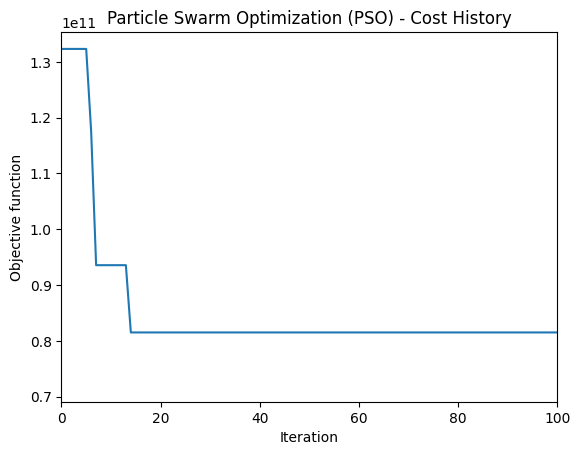

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
                              
Melhor partícula: 86124994041.75409


In [225]:
# Plotar gráfico de densidade da otimização
plt.figure()
plt.plot(optimizer.cost_history)
plt.xlabel('Iteration')
plt.xlim(0, max_iterations)
plt.ylabel('Objective function')
plt.title('Particle Swarm Optimization (PSO) - Cost History')
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("                              ")
print("Melhor partícula:", pbest_cost[0])

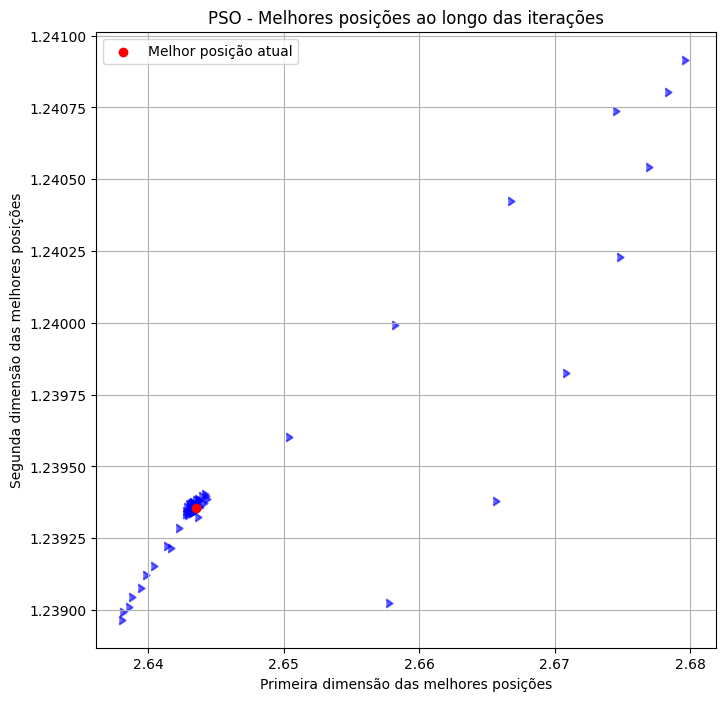

In [227]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], marker=m, c='blue', alpha=0.6)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], c='red', label='Melhor posição atual')

ax.set_title('PSO - Melhores posições ao longo das iterações')
ax.set_xlabel('Primeira dimensão das melhores posições')
ax.set_ylabel('Segunda dimensão das melhores posições')
ax.legend()
plt.grid()
plt.show()